<a href="https://colab.research.google.com/github/shubhamrai1318/Recommendation_System_for_E-commerce/blob/main/Recommendation_For_Ecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation System for E-commerce**

## **Importing libraries**


In [40]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

## **Loading Dataset**

In [41]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Loading the Dataset
file_path = '/content/drive/MyDrive/Shubham/CsvFiles/ratings_Electronics.csv'
df = pd.read_csv(file_path)

## **Data Manipulation**

In [43]:
df

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [44]:
# Adding Column Names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [45]:
# Dropping timestamp
df = df.drop('timestamp', axis=1)

In [46]:
# Rows and Columns of Dataset
rows, columns = df.shape
print("There are", rows , "Rows")
print("There are", columns,"Columns")

There are 7824481 Rows
There are 3 Columns


In [47]:
# Datatypes of Columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [48]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [49]:
# Summary statistics of 'rating' variable
df.describe()

,rating
count,7.824481e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [50]:
# Finding the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


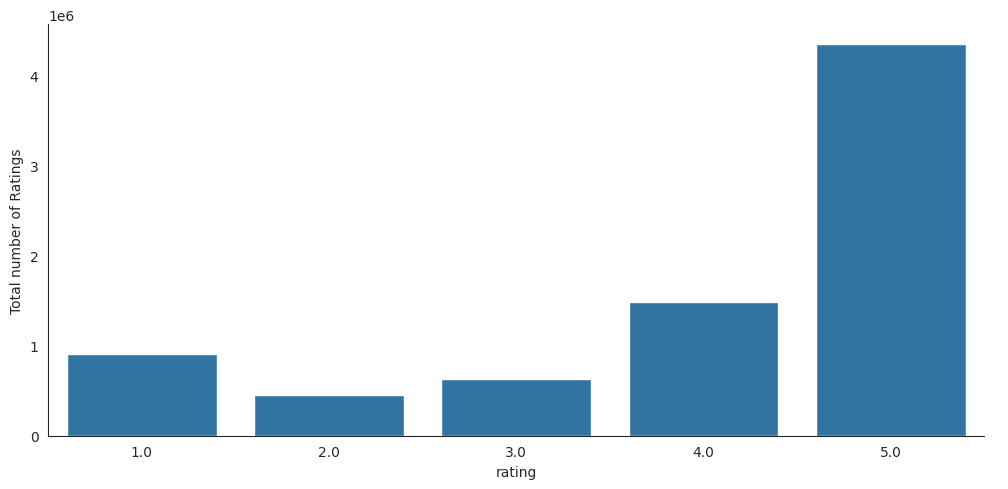

In [51]:
# Checking the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=df, aspect=2.0, kind='count')
    g.set_ylabels("Total number of Ratings")


In [52]:
# Number of unique user id  in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique PRODUCTS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique PRODUCTS in Raw data =  476001


In [53]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
dtype: int64

### Preprocessing

In [54]:
counts=df.user_id.value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]
print('Number of users who have rated 25 or more items =', len(df_final))
print('Number of unique users in the final data = ', df_final['user_id'].nunique())
print('Number of unique products in the final data = ', df_final['prod_id'].nunique())

Number of users who have rated 25 or more items = 125871
Number of unique users in the final data =  1540
Number of unique products in the final data =  48190


### **Rating Analysis of Final Dataset**

In [55]:
# Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

# Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

# Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

# Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


## **1.Popularity Based Recommendation System**

### **Creating Function for getting top n Popular Products**

In [56]:
def popularity_based_recommendation(df, top_n=5):

    # Checking if DataFrame is empty
    if df.empty:
        return "DataFrame is empty. Please provide valid data."

    # Calculating the count of ratings for each product
    popularity_df = df.groupby('prod_id').count()['rating'].reset_index()
    popularity_df.columns = ['prod_id', 'rating_count']

    # Checking if there are products in the DataFrame
    if popularity_df.empty:
        return "No products found in the provided data."

    # Sorting the products by the count of ratings in descending order
    popularity_df = popularity_df.sort_values(by='rating_count', ascending=False)

    # Displaying the top N popular products
    recommendations = popularity_df.head(top_n)

    return recommendations


### **Print Top n Popular Products with the help of *popularity_based_recommendation* function**

In [57]:
top_n_popular_products = 10
recommendations = popularity_based_recommendation(df, top_n_popular_products)

if isinstance(recommendations, str):
    print(recommendations)
else:
    print(f"Top {top_n_popular_products} Popular Products:")
    print(recommendations[['prod_id', 'rating_count']])


Top 10 Popular Products:
           prod_id  rating_count
308397  B0074BW614         18244
429571  B00DR0PDNE         16454
327307  B007WTAJTO         14172
102803  B0019EHU8G         12285
296624  B006GWO5WK         12226
178600  B003ELYQGG         11617
178812  B003ES5ZUU         10276
323012  B007R5YDYA          9907
289774  B00622AG6S          9823
30275   B0002L5R78          9487


## **2.Rank Based Recommendation System**

In [58]:
# Calculating the average rating and count of ratings for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
count_rating = df_final.groupby('prod_id')['rating'].count()

In [59]:
# Creating a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [60]:
# Sorting the dataframe by average of ratings in descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

In [61]:
# Displaying the top-rated products
top_rated_products = final_rating.head()
print(top_rated_products)

            avg_rating  rating_count
prod_id                             
0594451647         5.0             1
B003RRY9RS         5.0             1
B003RR95Q8         5.0             1
B003RIPMZU         5.0             1
B003RFRNYQ         5.0             2


### **Creating Fuction to get the top n products based on highest average rating and minimum interactions**

In [62]:
def get_top_n_products(final_ratings_df, num_products, min_interaction_count):
    # Checking if the final_ratings_df DataFrame is empty or not
    if final_ratings_df.empty:
        print("Error: The final_ratings_df DataFrame is empty.")
        return []

    # Checking if num_products is greater than the number of available products or not
    if num_products > len(final_ratings_df):
        print("Warning: Requested number of top products is greater than the number of available products.")
        num_products = len(final_ratings_df)

    # Filtering products with the minimum number of interactions
    recommended_products = final_ratings_df[final_ratings_df['rating_count'] > min_interaction_count]

    # Checking if there are products with the required number of interactions
    if recommended_products.empty:
        print(f"Error: No products with at least {min_interaction_count} interactions found.")
        return []

    # Sorting values based on average rating in descending order
    recommended_products = recommended_products.sort_values('avg_rating', ascending=False)

    # Checking if there are enough products to fulfill the request
    if num_products > len(recommended_products):
        print(f"Warning: Requested number of top products is greater than the number of products with at least {min_interaction_count} interactions.")
        num_products = len(recommended_products)

    # Returning the top n product IDs
    return recommended_products.index[:num_products].tolist()

### **Creating Function for Printing the top n products based on highest average rating and minimum interactions**

In [63]:
def print_top_products(products, n, min_interactions):
    if not products:
        print(f"Error: No top products with at least {min_interactions} interactions were found.")
    else:
        print(f"Top {n} products with at least {min_interactions} interactions:")
        for i, product in enumerate(products, start=1):
            print(f"{i}. Product ID: {product}")

### **Recommending top 5 Products with 50 Interactions with the help of *print_top_products* Function**


In [64]:
# Printing results of top 5 products with at least 50 interactions:
top_products_50_interactions = get_top_n_products(final_rating, 5, 50)
print_top_products(top_products_50_interactions, 5, 50)

Top 5 products with at least 50 interactions:
1. Product ID: B001TH7GUU
2. Product ID: B003ES5ZUU
3. Product ID: B0019EHU8G
4. Product ID: B006W8U2MU
5. Product ID: B000QUUFRW


### **Recommending top 10 Products with 100 Interactions with 50 Interactions with the help of *print_top_products* Function**

In [65]:
# Printing results of top 10 products with at least 100 interactions:
top_products_100_interactions = get_top_n_products(final_rating, 10, 100)
print_top_products(top_products_100_interactions, 10, 100)

Top 10 products with at least 100 interactions:
1. Product ID: B003ES5ZUU
2. Product ID: B000N99BBC
3. Product ID: B007WTAJTO
4. Product ID: B002V88HFE
5. Product ID: B004CLYEDC
6. Product ID: B00834SJSK
7. Product ID: B0034CL2ZI
8. Product ID: B00834SJNA
9. Product ID: B00829TIEK
10. Product ID: B00829THK0


## **3.Collaborative Filtering Recommendation System.**

### **3(a). User based collaborative filtering**

In [66]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [69]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [70]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

#### **Finding out top 10 similar users to the user index 1521 and their similarity score**

In [71]:
similar = similar_users(1521, final_ratings_matrix)[0][0:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [72]:
#Print the similarity score
similar_users(1521,final_ratings_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

#### **Function to Recommend Products**

In [73]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

In [74]:
# Recommend 5 products to user index 3 based on similarity based collaborative filtering
recommendations(3,5,final_ratings_matrix)

['B000067SF5', 'B0051PGX2I', 'B001GCQ3KM', 'B00015Y0FK', 'B00000J1V8']

In [75]:
# Recommend 5 products to user index 1521 based on similarity based collaborative filtering
recommendations(1521,5,final_ratings_matrix)

['B0035JJJQE', 'B005LIDMYM', 'B0028AD7BE', 'B0034CL2ZI', 'B002FB684E']

In [76]:
df

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0
...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824477,A322MDK0M89RHN,BT008UKTMW,5.0
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0


### **3(b). Model based Collaborative Filtering:**

In [77]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

#### **Creating a Reader Object**

In [78]:
reader = Reader(rating_scale=(1, 5))

In [79]:
# Load the DataFrame into the Surprise Dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)

In [80]:
# Splitting the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [81]:
# Building the SVD model
model = SVD(n_factors=50, random_state=42)

In [82]:
# Training the model
model.fit(trainset)

In [83]:
# Making predictions on the test set
predictions = model.test(testset)

#### **Evaluating the Model Performance**

In [84]:
# Evaluate the model performance (Root Mean Squared Error)
accuracy = rmse(predictions)
print(f'RMSE on the test set: {accuracy}')


RMSE: 1.2911
RMSE on the test set: 1.2910831745760347


#### **Checking the Recommendation Model**

In [86]:
df

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0
...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824477,A322MDK0M89RHN,BT008UKTMW,5.0
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0


In [89]:
# Specify the user for whom recommendations are needed
user_id_to_predict = 'A2NWSAGRHCP8N5'

# Initialize a list to store recommended items
items_to_recommend = []

# Iterate over unique product IDs in the dataset
for item_id in df['prod_id'].unique():
    # Check if the user has not interacted with the item
    if not trainset.knows_item(item_id):
        # Predict the rating for the user-item pair
        predicted_rating = model.predict(user_id_to_predict, item_id).est
        # Append the item and its predicted rating to the recommendation list
        items_to_recommend.append((item_id, predicted_rating))

# Sort the recommendations by predicted rating in descending order
items_to_recommend.sort(key=lambda x: x[1], reverse=True)

# Get the top N recommendations (e.g., top 5)
top_recommendations = items_to_recommend[:5]

# Print the Top N Recommendations in a Nice Format
print(f'\nTop 5 Recommendations for User {user_id_to_predict} is:\n')
for rank, (item_id, predicted_rating) in enumerate(top_recommendations, 1):
    print(f'{rank}. Product ID: {item_id} | Predicted Rating: {predicted_rating:.2f}\n')

print("Enjoy your shopping!")



Top 5 Recommendations for User A2NWSAGRHCP8N5 is:

1. Product ID: B00COYOAYW | Predicted Rating: 4.90

2. Product ID: B005ZKKJYC | Predicted Rating: 4.90

3. Product ID: B002HZW6WQ | Predicted Rating: 4.88

4. Product ID: B004GF8TIK | Predicted Rating: 4.82

5. Product ID: B000053HC5 | Predicted Rating: 4.78

Enjoy your shopping!
